<a href="https://colab.research.google.com/github/bibekebib/Dog-image-generation-using-autoencoder/blob/main/autoencoder_dog_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import files
files.upload()

In [4]:
!chmod -600 kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [6]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

100% 750M/750M [00:04<00:00, 191MB/s]
100% 750M/750M [00:04<00:00, 180MB/s]


In [7]:
%%capture
!unzip stanford-dogs-dataset.zip

In [8]:
import os
os.remove('stanford-dogs-dataset.zip')
!rm -r '/content/annotations'

In [9]:
import matplotlib.pyplot as plt
import cv2

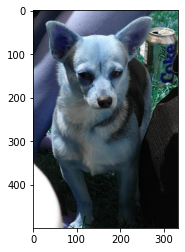

In [10]:
img = cv2.imread('/content/images/Images/n02085620-Chihuahua/n02085620_10074.jpg')
plt.imshow(img)
plt.show()

In [11]:
from glob import glob
import numpy as np
import pandas as pd


In [12]:
len(glob('/content/images/Images/*/*.jpg'))


20580

In [13]:
df = pd.DataFrame(glob('/content/images/Images/*/*.jpg'), columns=['path'])

In [14]:
df.head()

,path
0,/content/images/Images/n02094114-Norfolk_terri...
1,/content/images/Images/n02094114-Norfolk_terri...
2,/content/images/Images/n02094114-Norfolk_terri...
3,/content/images/Images/n02094114-Norfolk_terri...
4,/content/images/Images/n02094114-Norfolk_terri...


In [15]:
size = len(df)

In [16]:
len(df)

20580

In [17]:
train = df[:int(size*0.8)]

In [18]:
test = df[int(size*0.8):]

In [19]:
len(test)

4116

In [20]:
train.to_csv('train.csv')
test.to_csv('test.csv')

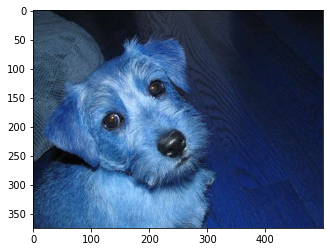

In [21]:
plt.imshow(cv2.imread(df.path[20]))

In [33]:
from skimage import io, color

In [98]:
class DogDataset(Dataset):
  def __init__(self, file):
    df = pd.read_csv(file)
    self.path = df.path
  
  def __len__(self):
    return len(self.path)
  
  def __getitem__(self, ix):
    f = self.path[ix]
    im  = cv2.imread(f)
    im = cv2.resize(im, (244,244))
    im = color.rgb2lab(im)
    im = im[:,:,0]
    im= np.resize(im,(244,244,1))
    return torch.tensor(im/255).permute(2,0,1).to(device).float()
    # return im.size()

In [99]:
train = DogDataset('train.csv')
test = DogDataset('test.csv')

In [100]:
data = train[10]


In [101]:
data.size()

torch.Size([1, 244, 244])

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


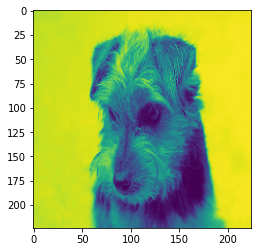

In [74]:
plt.imshow(data.permute(1,2,0).resize(224,224).cpu())
plt.show()

In [102]:
from torch import nn
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = ConvAutoEncoder().to(device)
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(2,1,244,244));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 20, 20]          --
|    └─Conv2d: 2-1                       [-1, 32, 82, 82]          320
|    └─ReLU: 2-2                         [-1, 32, 82, 82]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 41, 41]          --
|    └─Conv2d: 2-4                       [-1, 64, 21, 21]          18,496
|    └─ReLU: 2-5                         [-1, 64, 21, 21]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 20, 20]          --
├─Sequential: 1-2                        [-1, 1, 244, 244]         --
|    └─ConvTranspose2d: 2-7              [-1, 32, 41, 41]          18,464
|    └─ReLU: 2-8                         [-1, 32, 41, 41]          --
|    └─ConvTranspose2d: 2-9              [-1, 16, 123, 123]        12,816
|    └─ReLU: 2-10                        [-

In [103]:
model = ConvAutoEncoder().to(device)

In [104]:
def train_batch(input, model, criterion, optimizer):
  model.train()
  optimizer.zero_grad()
  output = model(input)
  loss = criterion(output, input)
  loss.backward()
  optimizer.step()
  return loss


In [105]:
@torch.no_grad()
def validate_batch(input, model, criterion):
  model.eval()
  output = model(input)
  loss = criterion(output, input)
  return loss

In [106]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [107]:
def get_data():
  train = DogDataset('train.csv')
  trn_dl = DataLoader(train, batch_size=32,shuffle=True, drop_last=True)
  val = DogDataset('test.csv')
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
  return trn_dl, val_dl

In [109]:
!pip install -q torch_snippets
from torch_snippets import *

In [112]:
trn_dl, val_dl  = get_data()
num_epochs = 5
log = Report(num_epochs)
for epoch in range(num_epochs):
  N = len(trn_dl)
  for ix, data in enumerate(trn_dl):
    loss = train_batch(data, model, criterion, optimizer)
    log.record(pos=(epoch + (ix+1)/N), \
    trn_loss=loss, end='\r')
    N = len(val_dl)
  for ix, data in enumerate(val_dl):
    loss = validate_batch(data, model, criterion)
    log.record(pos=(epoch + (ix+1)/N), \
    val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(398.46s - 1593.83s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(399.19s - 1596.78s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(399.93s - 1599.73s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(400.72s - 1602.87s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(401.46s - 1605.83s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(402.20s - 1608.79s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(402.93s - 1611.72s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(403.65s - 1614.61s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(404.41s - 1617.65s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(405.14s - 1620.58s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(405.91s - 1623.64s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(406.65s - 1626.58s remaining)
EPOCH: 1.000	trn_loss: 0.001	val_loss: 0.001	(407.39s - 1629.56s remaining)
EPOCH: 1.000

100%|██████████| 106/106 [00:00<00:00, 1223.87it/s]


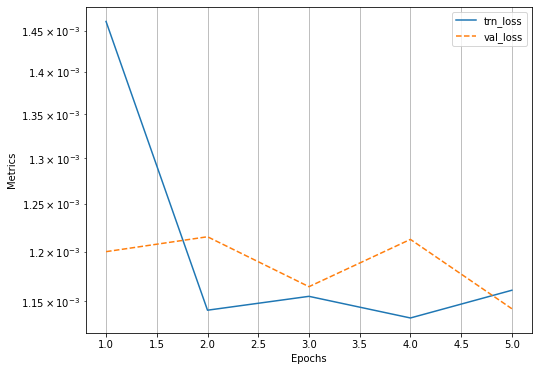

In [113]:
log.plot_epochs(log=True)

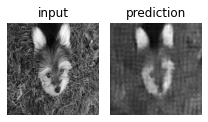

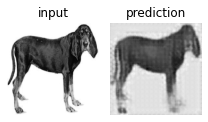

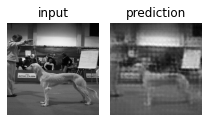

In [118]:
for _ in range(3):
  ix = np.random.randint(len(test))
  im = test[ix]
  _im = model(im[None])[0]
  fig, ax = plt.subplots(1, 2, figsize=(3,3))
  show(im[0], ax=ax[0], title='input')
  show(_im[0], ax=ax[1], title='prediction')
  plt.tight_layout()
  plt.show()